In [23]:
import re
import nltk
import fasttext
from nltk.corpus import stopwords


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dense, Input, Flatten
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 2000000
EMBEDDING_DIM = 100

In [3]:
df = pd.read_csv("Reviews.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
data = df.sample(n=20000)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 450040 to 423735
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      20000 non-null  int64 
 1   ProductId               20000 non-null  object
 2   UserId                  20000 non-null  object
 3   ProfileName             20000 non-null  object
 4   HelpfulnessNumerator    20000 non-null  int64 
 5   HelpfulnessDenominator  20000 non-null  int64 
 6   Score                   20000 non-null  int64 
 7   Time                    20000 non-null  int64 
 8   Summary                 19997 non-null  object
 9   Text                    20000 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.7+ MB


In [7]:
data.reset_index(inplace=True, drop=True)

In [8]:
wl = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()

In [9]:
def preprocess(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z\s]','',text)
    stop = stopwords.words('english')
    text = [ps.stem(wl.lemmatize(word)) for word in text.split() if word not in stop]
    return text
    

In [10]:
processed_data = data['Text'].map(preprocess)

In [11]:
tokenizer = Tokenizer()#num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Text'])
sequences = tokenizer.texts_to_sequences(data['Text'])

word_index = tokenizer.word_index
len(word_index)

29680

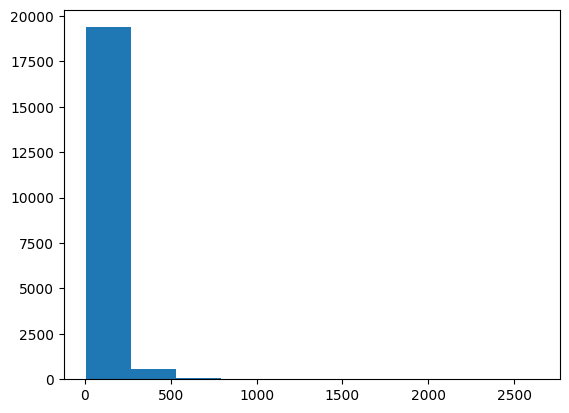

In [12]:
dct = []
for i in sequences:
    dct.append(len(i))
        
plt.hist(dct)
plt.show()

In [13]:
final = pad_sequences(sequences, MAX_SEQUENCE_LENGTH)
labels = pd.get_dummies(data['Score'],dtype='int')
final.shape, labels.shape

((20000, 100), (20000, 5))

In [14]:
labels.head()

,1,2,3,4,5
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,1,0,0
3,1,0,0,0,0
4,0,0,0,0,1


In [15]:
x_train, x_test, y_train, y_test = train_test_split(final, labels, test_size = 0.2, random_state = 20)
x_test, x_val, y_test, y_val = train_test_split( final, labels, test_size=0.50, random_state=4)
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((16000, 100), (10000, 100), (10000, 100), (16000, 5), (10000, 5), (10000, 5))

In [16]:
# using fasttext
embd = fasttext.load_model(r"fasttext_embedding_model.bin")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embd.get_word_vector(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

In [17]:
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(128,fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)   
l_merge = Concatenate()(convs)
l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
# l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
# l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool1)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             2968100   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 98, 128)              38528     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 97, 128)              51328     ['embedding[0][0]']           
                                                                                              

In [18]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=25, batch_size=150)

Epoch 1/25
107/107 [==============================] - 42s 350ms/step - loss: 0.3648 - acc: 0.6383 - val_loss: 0.3263 - val_acc: 0.6461
Epoch 2/25
107/107 [==============================] - 36s 340ms/step - loss: 0.3022 - acc: 0.6676 - val_loss: 0.2704 - val_acc: 0.6919
Epoch 3/25
107/107 [==============================] - 45s 417ms/step - loss: 0.2559 - acc: 0.7172 - val_loss: 0.2320 - val_acc: 0.7376
Epoch 4/25
107/107 [==============================] - 40s 375ms/step - loss: 0.2178 - acc: 0.7621 - val_loss: 0.2143 - val_acc: 0.7887
Epoch 5/25
107/107 [==============================] - 40s 372ms/step - loss: 0.1744 - acc: 0.8154 - val_loss: 0.1749 - val_acc: 0.8499
Epoch 6/25
107/107 [==============================] - 38s 353ms/step - loss: 0.1276 - acc: 0.8727 - val_loss: 0.1336 - val_acc: 0.8940
Epoch 7/25
107/107 [==============================] - 37s 348ms/step - loss: 0.0833 - acc: 0.9281 - val_loss: 0.1156 - val_acc: 0.9180
Epoch 8/25
107/107 [==============================] - 3

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


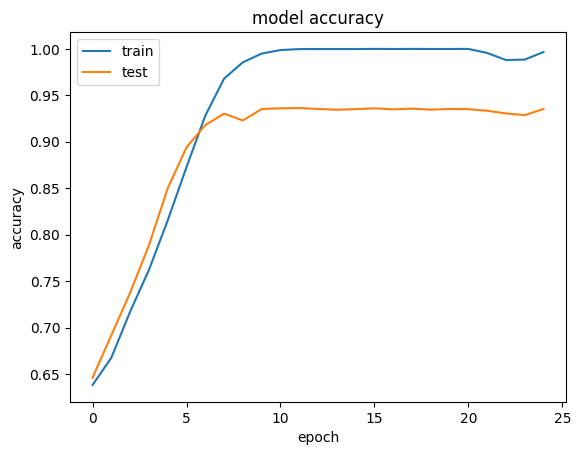

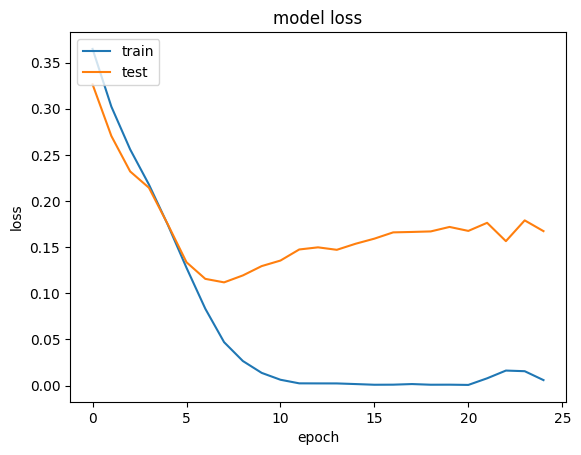

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
y_pred = model.predict(x_test, verbose=1)

313/313 [==============================] - 25s 66ms/step


In [21]:
def fx(array):
    return np.argmax(array)

temp = np.array(y_test)
st_pred = y_pred.tolist()
st_temp = temp.tolist()

arr = np.array(list(map(fx,st_temp)))
ans = np.array(list(map(fx,st_pred)))
f1 = f1_score(arr,ans, average='micro')
r1 = recall_score(arr, ans, average='micro')
p1 = precision_score(arr,ans, average='micro')
acc = accuracy_score(arr,ans)
print('f1',f1)
print('r1',r1)
print('p1',p1)
print('acc', acc)

f1 0.9377
r1 0.9377
p1 0.9377
acc 0.9377


In [24]:
cm = confusion_matrix(arr, ans)
cm

array([[ 785,   22,   13,    2,   42],
       [  25,  462,   16,   10,   25],
       [  13,   17,  623,   21,   46],
       [   9,   19,   30, 1222,  164],
       [  14,   15,   31,   89, 6285]], dtype=int64)